In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV as gcv
import xgboost as xgb

# Set working path
path = '/Users/martinbogaert/Desktop/NBA Data Analysis/2022-2023 Awards Project clean/'

In [3]:
data = pd.read_csv(path + 'Algorithm/dpoy/dpoy_data.csv')
data['BLK+STL'] = data['BLK'] + data['STL']

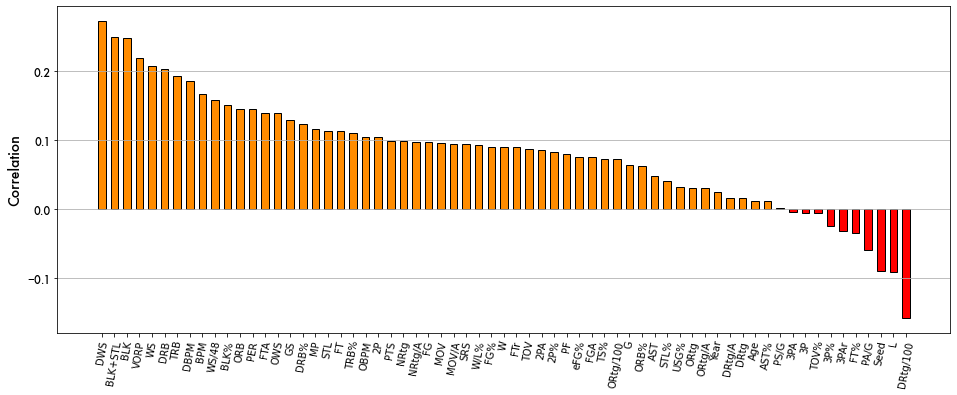

In [4]:
corr_df = data.corr().sort_values('Share', ascending = False)

plt.figure(figsize = (16, 6))

plt.bar(corr_df[corr_df['Share'] >= 0].index[1:], corr_df[corr_df['Share'] >= 0]['Share'][1:],
                        width = 0.6, color = 'darkorange', edgecolor = 'black')
plt.bar(corr_df[corr_df['Share'] < 0].index, corr_df[corr_df['Share'] < 0]['Share'],
                        width = 0.6, color = 'red', edgecolor = 'black')

#plt.plot(range(1, len(corr_df)), corr_df['Share'][1:], alpha = 0.5, linestyle = '-', c = 'black')
plt.xticks(rotation = 80)
plt.yticks(fontname = 'futura', size = 11)
plt.ylabel('Correlation', fontname = 'futura', size = 14)
plt.grid(axis = 'y')
plt.show()

In [5]:
features = ['DWS','BLK','STL','BLK%','DRB','DBPM','Seed','DRtg/A']
features = ['DWS','DBPM','STL','BLK','DRB','PA/G','BLK%','DRtg/100','MP']

In [6]:
years = np.arange(1988, 2023)
dfs = []

for year in years:
    
    print(f'Processing {year-1}-{year} season ...')
    clear_output(wait = True)
    
    X_train = data[data['Year'] < year]
    X_test = data[data['Year'] == year]
    
    model = RandomForestRegressor(n_estimators = 100, max_features = 'auto', min_samples_leaf = 2)
    model.fit(X_train[features], X_train['Share'])
    
    # Predict shares of test data
    pred = model.predict(X_test[features])
    X_test = X_test.assign(pred = pred)
    mse = mean_squared_error(pred, X_test['Share'])
    r2 = r2_score(pred, X_test['Share'])
    
    X_test['Rank'] = [len(X_test[X_test['Share'] > share])+1 for share in X_test['Share']] # Add rank
    X_test['Pred. rank'] = [len(X_test[X_test['pred'] > share])+1 for share in X_test['pred']] # Add predicted rank
    
    X_pred = X_test.sort_values('pred').tail(1)[['Year', 'Player', 'pred', 'Rank']].rename(columns = {'Player' : 'Pred. DPOY'})
    X_test = X_test.sort_values('Share').tail(1)[['Year', 'Player', 'Share', 'Pred. rank']].rename(columns = {'Player' : 'DPOY'})
    
    dfs.append(X_test.merge(X_pred, on = 'Year').assign(mse = mse, r2 = r2))

Processing 2021-2022 season ...


In [95]:
res = pd.concat(dfs)
res['correct'] = [True if act == pred else False for act, pred in zip(res['DPOY'], res['Pred. DPOY'])]
print('Accuracy :', round(100*res['correct'].mean(), 2), '%')
print('Mean squared error :', round(100*res['mse'].mean(), 3))
print('R2-score :', round(res['r2'].mean(), 3))
res.set_index('Year')

Accuracy : 40.0 %
Mean squared error : 0.112
R2-score : -5.677


,DPOY,Share,Pred. rank,Pred. DPOY,pred,Rank,mse,r2,correct
Year,,,,,,,,,
1988,Michael Jordan,0.463,1,Michael Jordan,0.107984,1,0.000575,-4.486210,True
1989,Mark Eaton,0.306,3,John Stockton,0.177544,9,0.000795,-2.684670,False
1990,Dennis Rodman,0.533,14,Hakeem Olajuwon,0.250175,2,0.001057,-1.722807,False
1991,Dennis Rodman,0.531,4,David Robinson,0.202929,2,0.000697,-1.260291,False
1992,David Robinson,0.479,1,David Robinson,0.297492,1,0.000362,0.171585,True
1993,Hakeem Olajuwon,0.745,1,Hakeem Olajuwon,0.255293,1,0.001118,-0.847939,True
1994,Hakeem Olajuwon,0.228,1,Hakeem Olajuwon,0.275551,1,0.000446,0.532196,True
1995,Dikembe Mutombo,0.429,4,David Robinson,0.141954,4,0.000507,-1.995176,False
1996,Gary Payton,0.496,4,Dikembe Mutombo,0.243054,3,0.000662,-0.829669,False


In [11]:
res['Pred. rank'].mean()

4.914285714285715

In [7]:
res = pd.concat(dfs)
res['correct'] = [True if act == pred else False for act, pred in zip(res['DPOY'], res['Pred. DPOY'])]
print('Accuracy :', round(100*res['correct'].mean(), 2), '%')
print('Mean squared error :', round(100*res['mse'].mean(), 3))
print('R2-score :', round(res['r2'].mean(), 3))
res.set_index('Year')

Accuracy : 45.71 %
Mean squared error : 0.114
R2-score : -6.03


,DPOY,Share,Pred. rank,Pred. DPOY,pred,Rank,mse,r2,correct
Year,,,,,,,,,
1988,Michael Jordan,0.463,1,Michael Jordan,0.146372,1,0.000483,-2.607790,True
1989,Mark Eaton,0.306,4,John Stockton,0.194430,9,0.000840,-2.560318,False
1990,Dennis Rodman,0.533,20,Hakeem Olajuwon,0.273095,2,0.001102,-1.414258,False
1991,Dennis Rodman,0.531,3,David Robinson,0.208404,2,0.000656,-0.862023,False
1992,David Robinson,0.479,1,David Robinson,0.272065,1,0.000357,0.250425,True
1993,Hakeem Olajuwon,0.745,1,Hakeem Olajuwon,0.229979,1,0.001150,-1.188084,True
1994,Hakeem Olajuwon,0.228,1,Hakeem Olajuwon,0.292963,1,0.000449,0.538885,True
1995,Dikembe Mutombo,0.429,6,David Robinson,0.174433,4,0.000527,-1.288573,False
1996,Gary Payton,0.496,4,Dikembe Mutombo,0.256273,3,0.000639,-0.632265,False


In [116]:
X_train = data[data['Year'] < 2022]
X_test = data[data['Year'] == 2022]

model = RandomForestRegressor(n_estimators = 100, max_features = 'auto', min_samples_leaf = 2)
model.fit(X_train[features], X_train['Share'])

# Predict shares of test data
pred = model.predict(X_test[features])
X_test = X_test.assign(pred = pred)

X_test['Rank'] = [len(X_test[X_test['Share'] > share])+1 for share in X_test['Share']] # Add rank
X_test['Pred. rank'] = [len(X_test[X_test['pred'] > share])+1 for share in X_test['pred']] # Add predicted rank

In [117]:
res_2022 = X_test.sort_values('Pred. rank')[['Player','Tm','Share', 'Rank', 'Pred. rank','pred']]

In [118]:
tm_col = {'ATL': '#e03a3e', 'BOS': 'green','BRK': 'gray','CHI': '#ce1141','CHO': 'aqua','CLE': 'maroon','DAL': 'cornflowerblue',
          'DEN': 'indigo','DET': 'royalblue','GSW': 'gold','HOU': 'lightcoral','IND': 'yellow','LAC': 'silver','LAL': '#fdb927','MEM': 'skyblue','MIA': 'hotpink',
          'MIL': '#00471b','MIN': 'lime','NOP': 'goldenrod','NYK': 'darkorange','OKC': 'dodgerblue','ORL': 'navy',
          'PHI': 'blue','PHO': 'orange','POR': '#cf0a2c','SAC': 'mediumslateblue','SAS': 'white','TOR': 'purple',
          'UTA': 'forestgreen','WAS': 'midnightblue'}

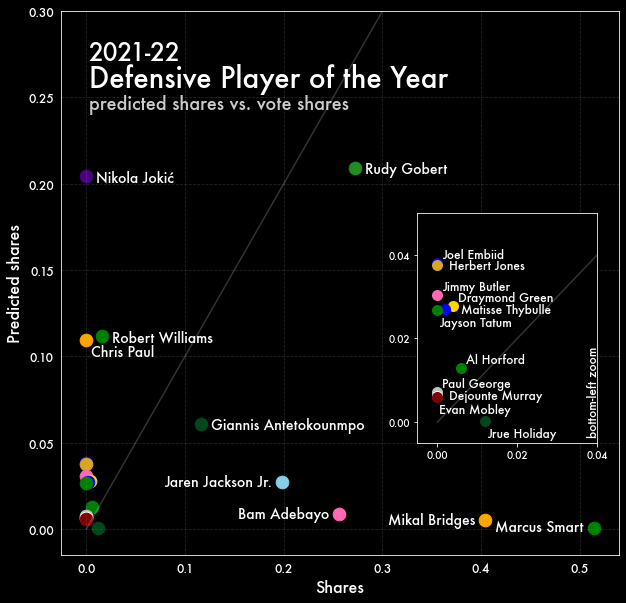

In [164]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = 'black')

plt.plot([0, max(res_2022['Share'].max(), res_2022['pred'].max())], [0, max(res_2022['Share'].max(), res_2022['pred'].max())], c = 'white', alpha = 0.2)

for player, share, pred, tm in zip(res_2022['Player'], res_2022['Share'], res_2022['pred'], res_2022['Tm']) :
    
    if pred > 0.0059 or share > 0:
        plt.scatter(share, pred, c = tm_col.get(tm), s = 160)
        
        if share >0.15 and player != 'Rudy Gobert':
            plt.annotate(player, xy = (share - 0.01, pred), fontname = 'futura', color = 'white', size = 14, va = 'center', ha = 'right')
            
        elif player == 'Chris Paul':
            plt.annotate(player, xy = (share + 0.005, pred-0.0025), fontname = 'futura', color = 'white', size = 14, va = 'top', ha = 'left')

        elif pred > 0.1 or share > 0.1 :
            plt.annotate(player, xy = (share + 0.01, pred - 0.005), fontname = 'futura', color = 'white', size = 14, va = 'bottom')
      
plt.ylabel('Predicted shares', color = 'white', size = 16, fontname = 'futura')
plt.xlabel('Shares', color = 'white', size = 16, fontname = 'futura')
plt.xticks(color = 'white', fontname = 'futura', size = 12)
plt.yticks(color = 'white', fontname = 'futura', size = 12)
plt.grid(linestyle = '--', alpha = 0.2)

### ANNOTATION ###
# Title
plt.annotate('2021-22', xy = (1/20, 0.91), fontname = 'futura', size = 24, xycoords = 'axes fraction', weight = 'bold', color = 'white') 
plt.annotate('Defensive Player of the Year', xy = (1/20, 0.86), fontname = 'futura', size = 28, xycoords = 'axes fraction', weight = 'bold', color = 'white')
# Sub-title
plt.annotate('predicted shares vs. vote shares', xy = (1/20, 0.82), fontname = 'futura', size = 18, xycoords = 'axes fraction', color = 'white', alpha = 0.8)
# Signature
#plt.annotate('@      .', xy = (0.875, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = 'white')
#plt.annotate('nba', xy = (0.9, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = '#ff9000')
#plt.annotate('ai', xy = (0.95, 0.16), fontname = 'futura', size = 14, alpha = 1, xycoords = 'axes fraction', color = '#ff58c4')

ax.spines['left'].set_color('white'); ax.spines['right'].set_color('white')
ax.spines['bottom'].set_color('white'); ax.spines['top'].set_color('white')
ax_gca = plt.gca()
plt.ylim([-0.015,0.3])
ax_gca.set_facecolor('black')

########

newax = fig.add_axes([0.62,0.28,0.25,0.32], zorder = 1)
newax.plot([0, 0.2], [0, 0.2], c = 'white', alpha = 0.2)

for player, share, pred, tm in zip(res_2022['Player'], res_2022['Share'], res_2022['pred'], res_2022['Tm']) :
    
    if share < 0.1 and pred < 0.05 :
        if share > 0 or pred > 0.0059 :
            newax.scatter(share, pred, c = tm_col.get(tm), s = 100)
            
            if player == 'Joel Embiid' or player == 'Draymond Green' or player == 'Paul George' or player == 'Jimmy Butler' or player == 'Al Horford' :
                newax.annotate(player, xy = (share+0.0012, pred+0.0005), fontname = 'futura', color = 'white', size = 12, va = 'bottom')
            elif player == 'Jayson Tatum' or player == 'Evan Mobley' or player == 'Jrue Holiday':
                newax.annotate(player, xy = (share+0.0005, pred-0.0015), fontname = 'futura', color = 'white', size = 12, va = 'top')
            elif player == 'Matisse Thybulle':
                newax.annotate(player, xy = (share+0.004, pred), fontname = 'futura', color = 'white', size = 12, va = 'center')
            else :
                newax.annotate(player, xy = (share+0.003, pred), fontname = 'futura', color = 'white', size = 12, va = 'center')

newax.set_xticks([0, 0.02, 0.04])
newax.set_yticks([0, 0.02, 0.04])
newax.tick_params(colors = 'white')

labels = newax.get_xticklabels() + newax.get_yticklabels()
[label.set_fontname('futura') for label in labels]

newax.annotate('bottom-left zoom', xy = (0.94, 1/25), fontname = 'futura', size = 12, xycoords = 'axes fraction', color = 'white', rotation = 90) 
newax.spines['left'].set_color('white'); newax.spines['right'].set_color('white')
newax.spines['bottom'].set_color('white'); newax.spines['top'].set_color('white')
newax.set_xlim([-0.005, 0.04]); newax.set_ylim([-0.005, 0.05])
ax_gca = plt.gca()
ax_gca.set_facecolor('black')

#plt.savefig(path + 'dpoy_2022_test.jpg', dpi = 300)
plt.show()

In [139]:
res_2022.head(25)

,Player,Tm,Share,Rank,Pred. rank,pred
15934,Rudy Gobert,UTA,0.272,3,1,0.209072
15550,Nikola Jokić,DEN,0.000,12,2,0.204215
15594,Robert Williams,BOS,0.016,7,3,0.111515
15573,Chris Paul,PHO,0.000,12,4,0.109672
15894,Giannis Antetokounmpo,MIL,0.116,6,5,0.060692
15561,Joel Embiid,PHI,0.000,12,6,0.038112
15690,Herbert Jones,NOP,0.000,12,7,0.037467
15869,Jimmy Butler,MIA,0.000,12,8,0.030455
15748,Draymond Green,GSW,0.004,10,9,0.027746
15941,Jaren Jackson Jr.,MEM,0.198,5,10,0.026994
